# Best area to live in LA

## Introduction
Moving to a new city is always exciting and stressful. It means the beginning of a new life. It also means that you need to find a neighborhood to live in and start your new life. I was moving to Los Angeles from an out-of-state a year ago, and the scene of searching for a new neighborhood online was still vivid. Due to my lack of familiar of the city I was going to, I spent a lot of time searching the Internet for the most suitable area to live in Los Angeles. Therefore, the objective of this project is to find the most suitable area to live in Los Angeles. Of course, this will be based on safety, convenience and economy consideration in order to provide some useful information to people who have just come to this city and want to find a new place to stay.


## Business Problem
In order to make this project more applicative, here we will concretize the problem we are about to solve, and introduce some assumptions and constraints.  
For choosing the most suitable area/neighborhood to live, the factors we consider include:
* Community safety: the lower the crime rate per capita, the more suitable the area to live
* Convenience level: we will measure the number of grocery stores, restaurants and shopping malls in the neighborhood 
* Entertainment activities: We will measure the number of art and entertainment venues, outdoor recreation venues and nightlife spots in the community
* Rent level: we will tend to live in areas where the average rent is relatively low 


## Target Audience 
This project is aimed at singles or families without children who want to relocate to Los Angeles, so educational resources are not considered for the time being. At the same time, due to the pandemic, most people are able to work from home, so the impact of commuting time on location selection is not considered here. In addition, the audience of this project is not limited to newcomers who have just arrived in LA. It is also instructive for people who already live in LA but want to reconsider their residential communities.


## Source of Data
In this project, we will fetch or extract data from the following sources:
* List of regions and neighborhoods in Los Angeles: <https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles>
* Los Angeles Rental Market Trends: https://www.rentcafe.com/average-rent-market-trends/us/ca/los-angeles/ 
* Violent crime in the City of Los Angeles from December 30, 2019 to June 28, 2020: https://maps.latimes.com/neighborhoods/violent-crime/neighborhood/list/ 
* Number of Arts & Entertainment, Food, Nightlife Spot, Outdoors & Recreation, and Shop & Service in every neighbourhood - **Foursquare API**
* Coordinates of all neighborhoods and venues - **GeoPy Nominatim geocoding**


### Import Required Libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import re

!pip install folium
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                                                         |failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - cffi -> python[version='2.7.*|3.5.*|3.6.*|3.6.12|>=3.6,<3.7.0a0|>=3.7,<3.8.0a0|>=3.9,<3.10.0a0|>=3.8,<3.9.0a0|3.6.9|3.6.9|3.6.9|>=2.7,<2.8.0a0|3.6.9|>=3.5,<3.6.0a0|3.4.*',build='0_73_pypy|1_73_pypy|2_73_pypy|4_73_pypy|3_73_pypy']
  - geopy -> python[version='2.7.*|3.4.*|3.5.*|3.6.*']
  - rsa -> python[version='2.7.*

# 1. Neighborhoods Data

#### First, we need to scrap a list of neighborhoods from the Wikipedia page-[List of districts and neighborhoods in Los Angeles](https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles)

In [5]:
# download data and parse it:
url = requests.get('https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles').text
soup = BeautifulSoup(url, "html.parser")

lis = []
for li in soup.findAll('li'):
    if li.find(href="/wiki/Portal:Los_Angeles"):
        break
    if li.find(href=re.compile("^/wiki/")):
        lis.append(li)
    if li.text=='Pico Robertson[34]': #Pico Robertson is the only item on the list that does not have a hyperlink reference
        lis.append(li)
len(lis)

200

#### There are total 200 neighborhoods in LA!

### Loading and Cleaning Neighborhood data

In [7]:
neigh = []
for i in range(0,len(lis)):
    neigh.append(lis[i].text.strip())
    
df = pd.DataFrame(neigh)
df.columns = ['Neighborhood']
df.head()

,Neighborhood
0,Angelino Heights[1]
1,Angeles Mesa[2]
2,Angelus Vista[2]
3,Arleta[3][1]
4,Arlington Heights[3]


In [8]:
df['Neighborhood'] = df.Neighborhood.str.partition('[')[0] #Removes the citation and reference brackets
df['Neighborhood'] = df.Neighborhood.str.partition(',')[0] #Removes the alternatives for 'Bel Air'
df=df[df.Neighborhood!='Baldwin Hills/Crenshaw'] #Removes redundancy as 'Baldwin Hills' and 'Crenshaw' exist already
df=df[df.Neighborhood!='Hollywood Hills West'] #Removes redundancy as it has the same coordinates as 'Hollywood Hills'
df=df[df.Neighborhood!='Brentwood Circle'] #Removes redundancy as it has the same coordinates as 'Brentwood'
df=df[df.Neighborhood!='Wilshire Park'] #Removes redundancy as it has the same coordinates as 'Wilshire Center'
df.reset_index(inplace=True,drop=True)
df.head()

,Neighborhood
0,Angelino Heights
1,Angeles Mesa
2,Angelus Vista
3,Arleta
4,Arlington Heights


### Get the latitude and the longitude coordinates of each neighborhood.

In [9]:
# define the data frame columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the data frame
nhoods = pd.DataFrame(columns=column_names)

# use GeoPy Nominatim geolocator with the user_agent "la_explorer".
geolocator = Nominatim(user_agent="la_explorer",timeout=5)
for i in range(0,len(df)):
    
    address = df.Neighborhood[i]+', Los Angeles'
    location = geolocator.geocode(address)
    if location == None:
        latitude = 0
        longitude = 0
    else:
        latitude = location.latitude
        longitude = location.longitude

    nhoods = nhoods.append({'Neighborhood': df.Neighborhood[i],
                                              'Latitude': latitude,
                                              'Longitude': longitude}, ignore_index=True)
print("The number of neighborhood before clean up is:",  len(nhoods))
nhoods.head()

The number of neighborhood before clean up is: 196


,Neighborhood,Latitude,Longitude
0,Angelino Heights,34.070289,-118.254796
1,Angeles Mesa,33.991402,-118.319520
2,Angelus Vista,-23.403598,-51.965818
3,Arleta,34.241327,-118.432205
4,Arlington Heights,34.043494,-118.321374


In [10]:
# clean neighbourhood data by deleting missing values and obvious geocoding errors
nhoods['Latitude']=nhoods['Latitude'].astype(float)
nhoods['Longitude']=nhoods['Longitude'].astype(float)

nhoods=nhoods[(nhoods.Latitude>33.5) & (nhoods.Latitude<34.4) & (nhoods.Longitude<-118)] 
nhoods.reset_index(inplace=True,drop=True)
nhoods.head()
print("The number of neighborhood after clean up is:",  len(nhoods))
nhoods

The number of neighborhood after clean up is: 161


,Neighborhood,Latitude,Longitude
0,Angelino Heights,34.070289,-118.254796
1,Angeles Mesa,33.991402,-118.319520
2,Arleta,34.241327,-118.432205
3,Arlington Heights,34.043494,-118.321374
4,Arts District,34.041239,-118.234450
5,Atwater Village,34.116398,-118.256464
6,Baldwin Hills,34.017616,-118.381694
7,Baldwin Village,34.019431,-118.345803
8,Beachwood Canyon,34.122292,-118.321384
9,Bel Air,34.082728,-118.447980


## Plot LA neighborhood map

#### Get the coordinates of the center of Los Angeles.

In [11]:
#Use geopy library to get the latitude and longitude values of Los Angeles.
address = 'Los Angeles, USA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.242766.


#### Create a map of Los Angeles with the neighborhood superimposed on top.

In [12]:
# create map of LA using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(nhoods['Latitude'], nhoods['Longitude'], nhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

# 2. Crime Data 

### To analyze the safety of the community, we will use the violent crime rate per 10,000 people from December 30, 2019 to June 28, 2020.  The table below contains both per capita statistics and gross crime counts.

In [13]:
# The code was removed by Watson Studio for sharing.

,Neighborhood,CrimePerCapital,CrimeCounts
0,Chesterfield Square,126.9,81
1,Vermont Vista,122.9,306
2,Vermont Knolls,110.4,238
3,Harvard Park,109.3,119
4,Broadway-Manchester,105.4,272


In [14]:
# merge neighbohood data with crime data
nhoods_crime=pd.merge(nhoods, crime_df, on='Neighborhood')

nhoods_crime.head()

,Neighborhood,Latitude,Longitude,CrimePerCapital,CrimeCounts
0,Arleta,34.241327,-118.432205,14.4,47
1,Arlington Heights,34.043494,-118.321374,28.7,67
2,Atwater Village,34.116398,-118.256464,5.2,8
3,Baldwin Hills,34.017616,-118.381694,41.1,132
4,Bel Air,34.082728,-118.447980,3.6,3


### Let's identify and visualize the top 10 neighborhoods with the lowest rates of violent crime per 10,000 people.

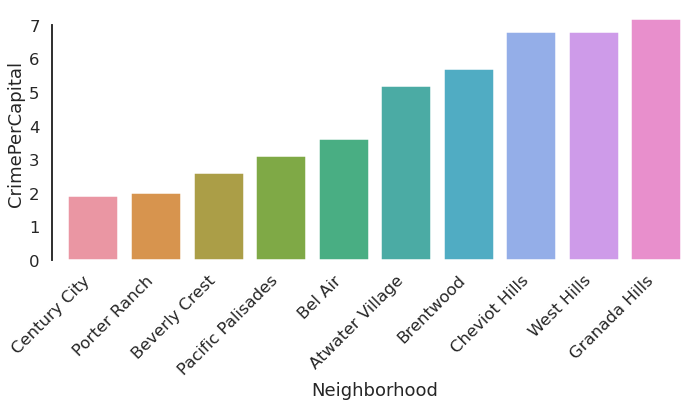

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

crime_top10=nhoods_crime.sort_values(['CrimePerCapital'], ascending=True).head(10)

plt.figure(figsize=(10, 6))

sns.set(style="white", context="talk", palette="rocket")

sns.barplot(
    data=crime_top10,
    x=crime_top10["Neighborhood"],
    y=crime_top10["CrimePerCapital"],
)

plt.xticks(rotation=45, ha='right')
sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)

# 3. Rent Data

### Rent is also a big factor in deciding where to live, so we collected the average monthly rent in different areas of Los Angeles.

In [16]:
body = client_936d2e8b22754b78ae27e343371ab102.get_object(Bucket='applieddatasciencecapstone-donotdelete-pr-hnyptdidd5gx3a',Key='average_rent_in_la.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

rent_df = pd.read_csv(body)
rent_df.head()


,Neighborhood,Average Rent
0,Adams - Normandie,3595
1,Arleta,1646
2,Arlington Heights,1490
3,Atwater Village,1994
4,Baldwin Hills,2200


In [17]:
# merge rent data with neighbohood and crime data
nhoods_crime_rent=pd.merge(nhoods_crime, rent_df, on='Neighborhood')

nhoods_crime_rent.head()

,Neighborhood,Latitude,Longitude,CrimePerCapital,CrimeCounts,Average Rent
0,Arleta,34.241327,-118.432205,14.4,47,1646
1,Arlington Heights,34.043494,-118.321374,28.7,67,1490
2,Atwater Village,34.116398,-118.256464,5.2,8,1994
3,Baldwin Hills,34.017616,-118.381694,41.1,132,2200
4,Bel Air,34.082728,-118.447980,3.6,3,2838


### Let's identify and visualize the top 10 neighborhoods with the lowest average rent in Los Angeles.

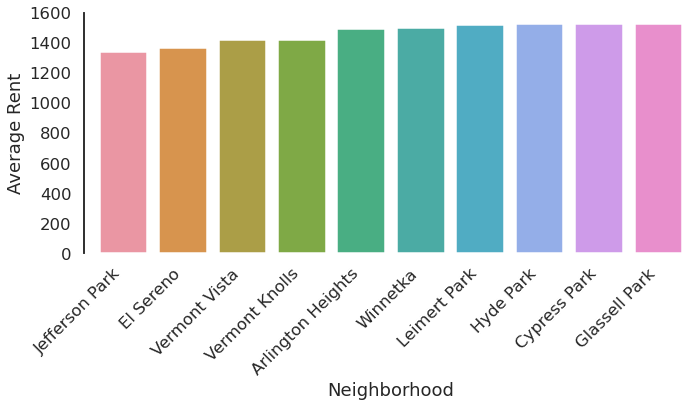

In [18]:
rent_top10=nhoods_crime_rent.sort_values(['Average Rent'], ascending=True).head(10)

plt.figure(figsize=(10, 6))

sns.set(style="white", context="talk", palette="rocket")

sns.barplot(
    data=crime_top10,
    x=rent_top10["Neighborhood"],
    y=rent_top10["Average Rent"],
)

plt.xticks(rotation=45, ha='right')
sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)

# 4. Venues Data (Foursquare API)

### Foursquare API will be used to provide information about venues and geolocation.

In [19]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'WFLZ4NIJIEJI4ZAXMK55TNQFLYM3CFJBWIQHJVY2YJRYU35U' #  Foursquare ID
CLIENT_SECRET = '5HMMA0ITDSSFF5U2YWAOBDANENUSHXXDTOGY2NBZR5DKGATN' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WFLZ4NIJIEJI4ZAXMK55TNQFLYM3CFJBWIQHJVY2YJRYU35U
CLIENT_SECRET:5HMMA0ITDSSFF5U2YWAOBDANENUSHXXDTOGY2NBZR5DKGATN


In [20]:
#create a function to explore all neighborhoods in LA.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
#write the code to run the above function on each neighborhood and create a new dataframe called toronto_denc_venues
la_venues = getNearbyVenues(names=nhoods_crime_rent['Neighborhood'],
                                   latitudes=nhoods_crime_rent['Latitude'],
                                   longitudes=nhoods_crime_rent['Longitude']
                                  )
la_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arleta,34.241327,-118.432205,Back To The Future Filming Location - McFly's ...,34.243429,-118.433655,Historic Site
1,Arleta,34.241327,-118.432205,Edwards Cinema,34.241197,-118.430284,Movie Theater
2,Arleta,34.241327,-118.432205,Canterbury & Kelowna,34.239525,-118.435370,Movie Theater
3,Arlington Heights,34.043494,-118.321374,Underground Museum,34.039758,-118.322934,Art Gallery
4,Arlington Heights,34.043494,-118.321374,Cafe Dabang,34.047407,-118.319082,Café


In [22]:
la_venues.drop_duplicates(keep="first", inplace=True)
len(la_venues)

2073

In [23]:
#find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(la_venues['Venue Category'].unique())))

There are 275 uniques categories.


In [24]:
def get_categories():
    try:
        with open("categories.json") as data:
            categories = json.load(data)
    except IOError:
        url = 'https://api.foursquare.com/v2/venues/categories'
        params = {
            "client_id": CLIENT_ID,
            "client_secret": CLIENT_SECRET,
            "v": VERSION,
        }
        categories = requests.get(url, params=params).json()["response"]["categories"]
    return categories

In [25]:
#the function return dictionaries of lists with parents and child categories
def collect_categories(node, categories):
    categories.append(node["name"])
    if not node["categories"]:
        return
    for sub_node in node['categories']:
        collect_categories(sub_node, categories)

In [26]:
#from list of dictionaries to one dictoinary
categories_list = {}
for i in get_categories():
    categories = []
    collect_categories(i, categories)
    categories_list[i["name"]] = categories

In [27]:
venueCat = []

for venue_category in la_venues["Venue Category"]:
    for key in categories_list.keys():
        if venue_category in categories_list[key]:
            venueCat.append(key)

la_venues["General Venue Category"] = venueCat

la_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Venue Category
0,Arleta,34.241327,-118.432205,Back To The Future Filming Location - McFly's ...,34.243429,-118.433655,Historic Site,Arts & Entertainment
1,Arleta,34.241327,-118.432205,Edwards Cinema,34.241197,-118.430284,Movie Theater,Arts & Entertainment
2,Arleta,34.241327,-118.432205,Canterbury & Kelowna,34.239525,-118.435370,Movie Theater,Arts & Entertainment
3,Arlington Heights,34.043494,-118.321374,Underground Museum,34.039758,-118.322934,Art Gallery,Arts & Entertainment
4,Arlington Heights,34.043494,-118.321374,Cafe Dabang,34.047407,-118.319082,Café,Food
5,Arlington Heights,34.043494,-118.321374,La Cevicheria,34.047654,-118.322810,Latin American Restaurant,Food
6,Arlington Heights,34.043494,-118.321374,Natraliart Jamaican Restaurant,34.039750,-118.322392,Restaurant,Food
7,Arlington Heights,34.043494,-118.321374,7-Eleven,34.044352,-118.326642,Convenience Store,Shop & Service
8,Arlington Heights,34.043494,-118.321374,Enterprise Rent-A-Car,34.046795,-118.318267,Rental Car Location,Travel & Transport
9,Arlington Heights,34.043494,-118.321374,Winchell's,34.043435,-118.323944,Donut Shop,Food


In [28]:
#find out what th genetal venue categories are
print('General Venue Categories include {}'.format((la_venues['General Venue Category'].unique())))

General Venue Categories include ['Arts & Entertainment' 'Food' 'Shop & Service' 'Travel & Transport'
 'Outdoors & Recreation' 'Nightlife Spot' 'Professional & Other Places'
 'College & University' 'Residence']


#### For this project, we only take Arts & Entertainment, Food, Shop & Service, Outdoors & Recreation and Nightlife Spot into consideration, so let's drop other general categories.

In [29]:
la_venues.drop(
    la_venues[
        (la_venues["General Venue Category"] == 'Travel & Transport') |
        (la_venues["General Venue Category"] == 'Professional & Other Places') |
        (la_venues["General Venue Category"] == 'Residence') |
        (la_venues["General Venue Category"] == 'College & University')
    ].index,
    axis=0,
    inplace=True,
)
 
la_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Venue Category
0,Arleta,34.241327,-118.432205,Back To The Future Filming Location - McFly's ...,34.243429,-118.433655,Historic Site,Arts & Entertainment
1,Arleta,34.241327,-118.432205,Edwards Cinema,34.241197,-118.430284,Movie Theater,Arts & Entertainment
2,Arleta,34.241327,-118.432205,Canterbury & Kelowna,34.239525,-118.435370,Movie Theater,Arts & Entertainment
3,Arlington Heights,34.043494,-118.321374,Underground Museum,34.039758,-118.322934,Art Gallery,Arts & Entertainment
4,Arlington Heights,34.043494,-118.321374,Cafe Dabang,34.047407,-118.319082,Café,Food
5,Arlington Heights,34.043494,-118.321374,La Cevicheria,34.047654,-118.322810,Latin American Restaurant,Food
6,Arlington Heights,34.043494,-118.321374,Natraliart Jamaican Restaurant,34.039750,-118.322392,Restaurant,Food
7,Arlington Heights,34.043494,-118.321374,7-Eleven,34.044352,-118.326642,Convenience Store,Shop & Service
9,Arlington Heights,34.043494,-118.321374,Winchell's,34.043435,-118.323944,Donut Shop,Food
10,Arlington Heights,34.043494,-118.321374,Restaurant World,34.040283,-118.323125,Shop & Service,Shop & Service


In [30]:
#define color for each general venue category
colorDict = {
    'Arts & Entertainment': 'yellow',
    'Food': 'orange',
    'Shop & Service': 'red',
    'Outdoors & Recreation': 'cadetblue',
    'Nightlife Spot': 'purple'
}


### Let's visualize general venue category on a map

In [31]:
from folium.plugins import MarkerCluster

venueMap = folium.Map(
    location=[latitude, longitude], 
    zoom_start=10
)

markCluster = MarkerCluster().add_to(venueMap)

for lat, lng, cat in zip(la_venues['Venue Latitude'],
                         la_venues['Venue Longitude'],
                         la_venues['General Venue Category']):  
    if cat in colorDict:
        folium.Marker(
            location=[lat, lng],
            icon=folium.Icon(color=colorDict[cat]),
        ).add_to(markCluster)
        
venueMap

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:16: UserWarning: color argument of Icon should be one of: {'lightgray', 'gray', 'orange', 'darkblue', 'black', 'lightred', 'white', 'blue', 'cadetblue', 'lightblue', 'beige', 'darkpurple', 'purple', 'darkred', 'lightgreen', 'pink', 'darkgreen', 'green', 'red'}.


### Analyze each neighborhood 

In [32]:
# one hot encoding
la_onehot = pd.get_dummies(la_venues[['General Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_onehot['Neighborhood'] = la_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [la_onehot.columns[-1]] + list(la_onehot.columns[:-1]) 
la_onehot = la_onehot[fixed_columns]

la_onehot.head()

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service
0,Arleta,1,0,0,0,0
1,Arleta,1,0,0,0,0
2,Arleta,1,0,0,0,0
3,Arlington Heights,1,0,0,0,0
4,Arlington Heights,0,1,0,0,0


In [33]:
#group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
la_grouped = la_onehot.groupby('Neighborhood').sum().reset_index()

la_grouped.head()
len(la_grouped)

94

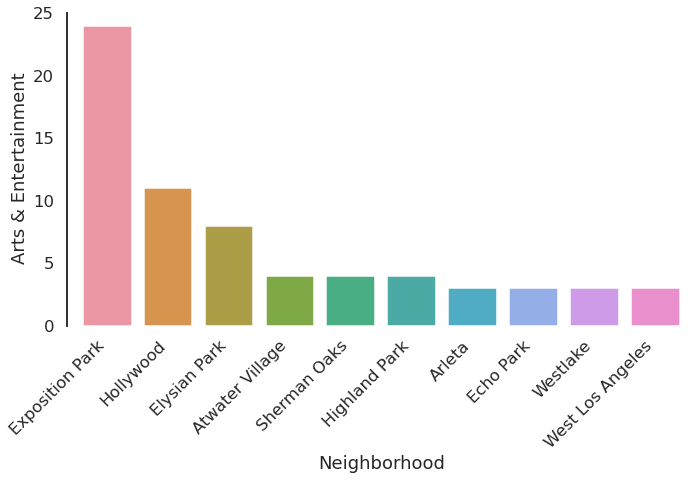

In [34]:
arts_top10=la_grouped.sort_values(['Arts & Entertainment'], ascending=False).head(10)

plt.figure(figsize=(10, 7))

sns.set(style="white", context="talk", palette="rocket")

sns.barplot(
    data=arts_top10,
    x=arts_top10["Neighborhood"],
    y=arts_top10["Arts & Entertainment"],
)

plt.xticks(rotation=45, ha='right')
sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)


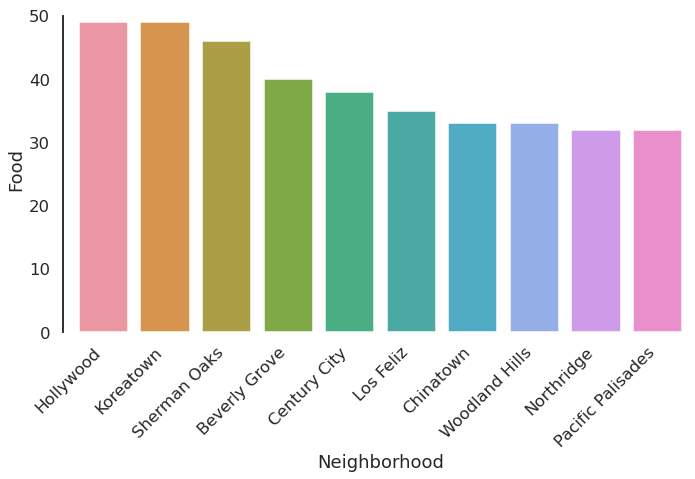

In [35]:
food_top10=la_grouped.sort_values(['Food'], ascending=False).head(10)

plt.figure(figsize=(10, 7))

sns.set(style="white", context="talk", palette="rocket")

sns.barplot(
    data=food_top10,
    x=food_top10["Neighborhood"],
    y=food_top10["Food"],
)

plt.xticks(rotation=45, ha='right')
sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)

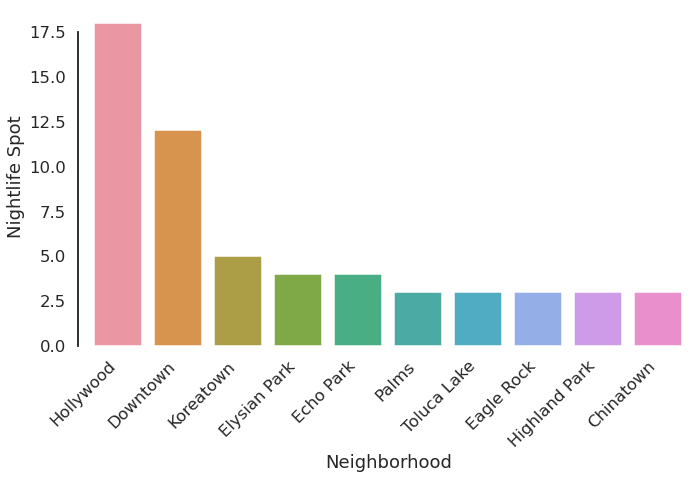

In [36]:
night_top10=la_grouped.sort_values(['Nightlife Spot'], ascending=False).head(10)

plt.figure(figsize=(10, 7))

sns.set(style="white", context="talk", palette="rocket")

sns.barplot(
    data=night_top10,
    x=night_top10["Neighborhood"],
    y=night_top10["Nightlife Spot"],
)

plt.xticks(rotation=45, ha='right')
sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)

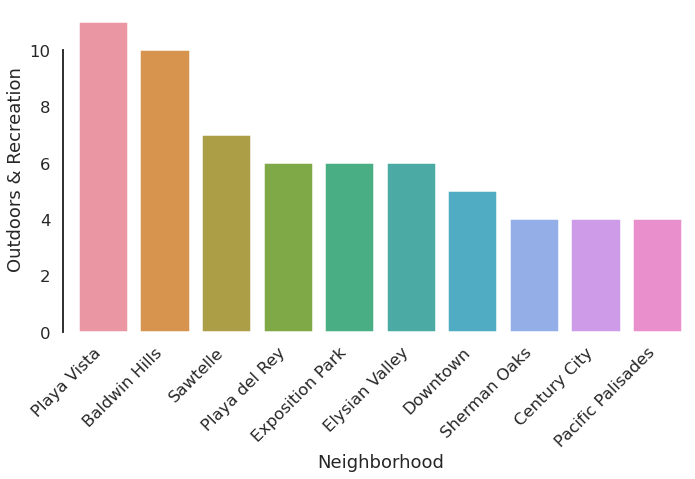

In [37]:
outdoors_top10=la_grouped.sort_values(['Outdoors & Recreation'], ascending=False).head(10)

plt.figure(figsize=(10, 7))

sns.set(style="white", context="talk", palette="rocket")

sns.barplot(
    data=outdoors_top10,
    x=outdoors_top10["Neighborhood"],
    y=outdoors_top10["Outdoors & Recreation"],
)

plt.xticks(rotation=45, ha='right')
sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)

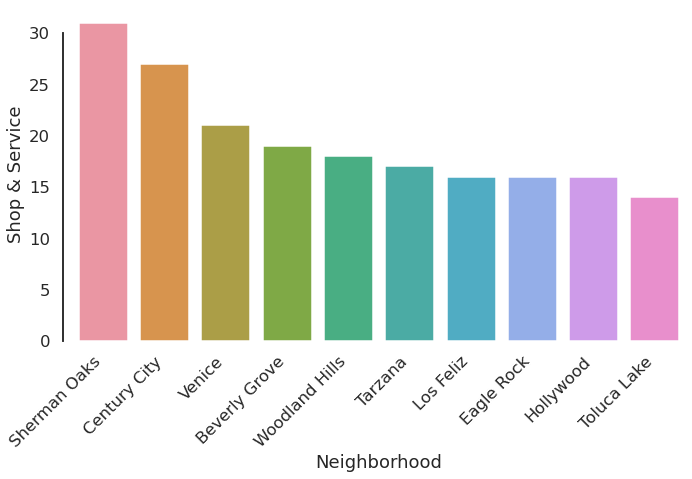

In [38]:
shop_top10=la_grouped.sort_values(['Shop & Service'], ascending=False).head(10)

plt.figure(figsize=(10, 7))

sns.set(style="white", context="talk", palette="rocket")

sns.barplot(
    data=shop_top10,
    x=shop_top10["Neighborhood"],
    y=shop_top10["Shop & Service"],
)

plt.xticks(rotation=45, ha='right')
sns.despine(offset=10, trim=True, bottom=True)
plt.tight_layout(h_pad=2)

# 5. Cluster Analysis 

### First, integrate venues data with the previous crime data and rent data.

In [39]:
la_df=pd.merge(nhoods_crime_rent, la_grouped, on='Neighborhood')
la_df.drop_duplicates(keep="first", inplace=True)
la_df.head()

,Neighborhood,Latitude,Longitude,CrimePerCapital,CrimeCounts,Average Rent,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service
0,Arleta,34.241327,-118.432205,14.4,47,1646,3,0,0,0,0
1,Arlington Heights,34.043494,-118.321374,28.7,67,1490,2,4,0,0,4
2,Atwater Village,34.116398,-118.256464,5.2,8,1994,4,16,2,2,13
3,Baldwin Hills,34.017616,-118.381694,41.1,132,2200,1,1,0,10,2
4,Bel Air,34.082728,-118.447980,3.6,3,2838,0,2,2,1,1


In [40]:
#create the new dataframe and display the top 1 venues for each neighborhood.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 1

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
la_sorted = pd.DataFrame(columns=columns)
la_sorted['Neighborhood'] = la_grouped['Neighborhood']

for ind in np.arange(la_grouped.shape[0]):
    la_sorted.iloc[ind, 1:] = return_most_common_venues(la_grouped.iloc[ind, :], num_top_venues)

la_sorted.drop_duplicates(keep="first", inplace=True)
la_sorted.head()

,Neighborhood,1st Most Common Venue
0,Arleta,Arts & Entertainment
1,Arlington Heights,Shop & Service
2,Atwater Village,Food
3,Baldwin Hills,Outdoors & Recreation
4,Bel Air,Nightlife Spot


### Normalizing over the standard deviation

#### Now let's normalize the dataset. Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. We use StandardScaler() to normalize our dataset.

In [ ]:
la_cluster = la_df.drop(columns=["Neighborhood", "Latitude", "Longitude","CrimeCounts"])

from sklearn.preprocessing import StandardScaler
X = la_cluster.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

### Modeling

#### Lets apply k-means on our dataset, and take look at cluster labels.

In [126]:
#Run k-means to cluster the neighborhood into 5 clusters.

# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 1, 2, 4, 0, 2, 1, 4, 1], dtype=int32)

In [127]:
#create a new dataframe that includes the cluster as well as the top 1 venues for each neighborhood.

# add clustering labels
la_df.insert(0, 'Cluster Labels', kmeans.labels_)

# merge la_df with la_sorted to add top 1 venues for each neighborhood
la_merged=pd.merge(la_df, la_sorted, on='Neighborhood')
la_merged.head()

,Cluster Labels,Neighborhood,Latitude,Longitude,CrimePerCapital,CrimeCounts,Average Rent,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,1st Most Common Venue
0,3,Arleta,34.241327,-118.432205,14.4,47,1646,3,0,0,0,0,Arts & Entertainment
1,3,Arlington Heights,34.043494,-118.321374,28.7,67,1490,2,4,0,0,4,Shop & Service
2,1,Atwater Village,34.116398,-118.256464,5.2,8,1994,4,16,2,2,13,Food
3,2,Baldwin Hills,34.017616,-118.381694,41.1,132,2200,1,1,0,10,2,Outdoors & Recreation
4,4,Bel Air,34.082728,-118.447980,3.6,3,2838,0,2,2,1,1,Nightlife Spot


In [128]:
#visualize the resulting clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        la_merged['Latitude'], 
        la_merged['Longitude'], 
        la_merged['Neighborhood'], 
        la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### We can easily check the centroid values by averaging the features in each cluster.

In [ ]:
df.groupby('Clus_km').mean()

#### Cluster 1

In [130]:
la_merged.loc[la_merged['Cluster Labels'] == 0, la_merged.columns[[1] + [4] +list(range(6, la_merged.shape[1]))]]

,Neighborhood,CrimePerCapital,Average Rent,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,1st Most Common Venue
5,Beverly Grove,52.1,3505,2,40,0,3,19,Food
10,Carthay,46.9,3321,1,15,0,0,3,Food
17,Del Rey,10.6,3252,0,11,1,0,5,Food
61,Playa Vista,13.3,3092,1,9,1,11,8,Outdoors & Recreation
80,Venice,34.2,3386,3,16,1,2,21,Shop & Service
90,Westwood,8.5,3261,0,3,0,0,0,Food


#### Cluster 2

In [131]:
la_merged.loc[la_merged['Cluster Labels'] == 1, la_merged.columns[[1] + [4] +list(range(6, la_merged.shape[1]))]]

,Neighborhood,CrimePerCapital,Average Rent,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,1st Most Common Venue
2,Atwater Village,5.2,1994,4,16,2,2,13,Food
7,Boyle Heights,28.0,1959,1,16,0,0,9,Food
9,Canoga Park,21.3,1941,0,9,1,1,9,Shop & Service
12,Chatsworth,13.2,1901,1,8,0,1,4,Food
13,Chesterfield Square,126.9,1796,0,3,0,0,2,Food
19,Eagle Rock,7.3,1918,2,31,3,2,16,Food
20,East Hollywood,29.3,2009,0,15,0,0,3,Food
21,Echo Park,19.8,2079,3,26,4,4,6,Food
24,Elysian Valley,9.0,1971,1,1,0,6,1,Outdoors & Recreation
25,Encino,8.5,1964,0,13,0,3,7,Food


#### Cluster 3

In [132]:
la_merged.loc[la_merged['Cluster Labels'] == 2, la_merged.columns[[1] + [4] +list(range(6, la_merged.shape[1]))]]

,Neighborhood,CrimePerCapital,Average Rent,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,1st Most Common Venue
3,Baldwin Hills,41.1,2200,1,1,0,10,2,Outdoors & Recreation
6,Beverlywood,10.9,2269,0,0,0,1,0,Outdoors & Recreation
14,Cheviot Hills,6.8,2313,0,0,0,1,0,Outdoors & Recreation
15,Chinatown,21.8,2387,2,33,3,2,3,Food
23,Elysian Park,15.0,2343,8,6,4,3,1,Arts & Entertainment
31,Hancock Park,21.6,2352,0,0,0,0,1,Shop & Service
34,Hollywood,49.1,2341,11,49,18,2,16,Food
35,Hollywood Hills,14.8,2167,0,0,0,2,0,Outdoors & Recreation
43,Lincoln Heights,21.3,2251,1,11,0,0,4,Food
47,Mid-City,27.8,2236,3,3,0,1,2,Food


#### Cluster 4

In [116]:
la_merged.loc[la_merged['Cluster Labels'] == 3, la_merged.columns[[1] + [4] +list(range(6, la_merged.shape[1]))]]

,Neighborhood,CrimePerCapital,Average Rent,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,1st Most Common Venue
2,Atwater Village,5.2,1994,4,16,2,2,13,Food
7,Boyle Heights,28.0,1959,1,16,0,0,9,Food
9,Canoga Park,21.3,1941,0,9,1,1,9,Shop & Service
12,Chatsworth,13.2,1901,1,8,0,1,4,Food
13,Chesterfield Square,126.9,1796,0,3,0,0,2,Food
19,Eagle Rock,7.3,1918,2,31,3,2,16,Food
20,East Hollywood,29.3,2009,0,15,0,0,3,Food
21,Echo Park,19.8,2079,3,26,4,4,6,Food
24,Elysian Valley,9.0,1971,1,1,0,6,1,Outdoors & Recreation
25,Encino,8.5,1964,0,13,0,3,7,Food


#### Cluster 5

In [133]:
la_merged.loc[la_merged['Cluster Labels'] == 4, la_merged.columns[[1] + [4] +list(range(6, la_merged.shape[1]))]]

,Neighborhood,CrimePerCapital,Average Rent,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service,1st Most Common Venue
4,Bel Air,3.6,2838,0,2,2,1,1,Nightlife Spot
8,Brentwood,5.7,2838,2,7,0,2,7,Shop & Service
11,Century City,1.9,2593,3,38,0,4,27,Food
18,Downtown,40.8,2534,2,23,12,5,6,Food
27,Fairfax,63.6,2684,2,15,2,0,11,Food
46,Mar Vista,10.1,2603,2,9,0,2,8,Food
59,Pico-Union,32.2,2758,0,15,0,0,3,Food
60,Playa del Rey,14.1,2484,0,9,0,6,4,Food
65,Sawtelle,12.9,2593,1,8,0,7,10,Shop & Service
85,West Adams,41.1,2503,0,4,1,0,2,Food
